## 載入所需套件


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
import math

## 載入特徵

In [3]:
#載入圖片特徵
#於image_feature.ipynb中實作並儲存
train_features = np.load('feature/train_features.npy', allow_pickle=True)
train_labels = np.load('feature/train_labels.npy', allow_pickle=True)
val_features = np.load('feature/val_features.npy', allow_pickle=True)
val_labels = np.load('feature/val_labels.npy', allow_pickle=True)
test_features = np.load('feature/test_features.npy', allow_pickle=True)
test_labels = np.load('feature/test_labels.npy', allow_pickle=True)

In [4]:
print(train_features.dtype)
print(train_labels.dtype)

object
<U2


## 資料處理

In [5]:
def one_hot_encoding(y):
    y=y.astype(int) #將label的0~49轉成數字
    num_classes = 50 #共50個label
    y_onehot = np.zeros((len(y), num_classes))
    y_onehot[np.arange(len(y)), y] = 1 #轉成one hot
    return y_onehot

def union_shuffle(X, y):
    X=X.astype(float) #features的原始讀取到的資料型態是object，轉成float
    index = np.arange(X.shape[0])
    np.random.shuffle(index) #將資料排序打亂
    return X[index], y[index]


In [6]:
# One-hot encode labels
y_train = one_hot_encoding(train_labels)
y_valid = one_hot_encoding(val_labels)
y_test = one_hot_encoding(test_labels)

# Shuffle data
x_train, y_train = union_shuffle(train_features, y_train)
x_valid, y_valid = union_shuffle(val_features, y_valid)
x_test, y_test = union_shuffle(test_features, y_test)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_train.dtype)
print(y_train.dtype)

(63325, 2916)
(63325, 50)
float64
float64


## Model
* reference
#### youtube合輯 - perceptron運作過程含程式教學 
###### https://youtube.com/playlist?list=PLqXS1b2lRpYTpUIEu3oxfhhTuBXmMPppA
#### ChatGPT

* Hyperparameter

In [8]:
input_size = 2916
hidden_size = 50
output_size = 50
batch_size = 32
epochs = 50
learning_rate = 1e-6

* 評估指標

In [9]:
def top5_acc(labels, probs):
    correct = 0
    for i, p in enumerate(probs):
        top5_y = np.argsort(p)[-5:]
        if labels[i] in top5_y:
            correct += 1
    
    return correct / len(labels)

* 激活函數

In [10]:
class relu():
    def forward(self, x):
        self.x = x
        return np.maximum(0, self.x)

    def backward(self, delta, weight):
        grad = np.dot(delta, weight)
        grad[self.x <= 0] = 0
        return grad

class softmax():
    def forward(self, x):
        self.x = np.exp(x)
        return self.x / np.sum(self.x, axis=1, keepdims=True)

    def backward(self, y_pred, y_true):
        return y_pred - y_true #計算輸出與實際標籤之間的誤差

* Loss Function

In [11]:
def CrossEntropy(probs, Y):
    """
    probs: 模型預測出的每個類別的機率，形狀為 (m, n_classes)
    Y: 真實標籤，形狀為 (m, n_classes)，其中每一行為 one-hot 編碼

    Returns:
    loss: 交叉熵損失
    """
    loss = -np.sum(Y * np.log(probs + 1e-12)) #為了避免出現機率為 0 導致的 log(0) 錯誤，將 probs 加上一個很小的數值 1e-12。
    return loss


* Two Layer Perceptron

In [12]:
class TwoLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size):
        self.relu = relu()
        self.softmax = softmax()
        #第一層 weight與bias
        self.w1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        #第二層 weight與bias 
        self.w2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros(output_size)
        
    def forward(self, x):
        # 第一層: ReLU激活函數
        self.x1 = np.dot(x, self.w1) + self.b1 #第一層的輸出
        self.a1 = self.relu.forward(self.x1) #第一層的輸出經過ReLU
        
        # 第二層: softmax計算各類別機率
        self.x2 = np.dot(self.a1, self.w2) + self.b2 #第二層的輸出
        self.output = self.softmax.forward(self.x2) #第二層的輸出經過softmax
        return self.output
        
    def backward(self, x, y, learning_rate):
        # 第二層
        error2 = self.softmax.backward(self.output, y) #計算輸出與實際標籤之間的誤差
        self.dw2 = np.dot(self.a1.T, error2) 
        self.db2 = np.sum(error2, axis=0)
        # 第一層
        error1 = self.relu.backward(error2, self.w2.T) 
        self.dw1 = np.dot(x.T, error1)
        self.db1 = np.sum(error1, axis=0)
        # 更新weight與bias
        self.w1 -= learning_rate * self.dw1
        self.w2 -= learning_rate * self.dw2
        self.b1 -= learning_rate * self.db1
        self.b2 -= learning_rate * self.db2
        
    def train(self, X_train, Y_train, X_val, Y_val, batch_size, epochs, learning_rate):
        acc_loss_list = []
        for epoch in range(epochs):
            train_top1_acc = 0
            train_top5_acc = 0
            train_loss = 0
            for i in range(0, len(X_train), batch_size):
                # get batch
                X_batch = X_train[i: i + batch_size]
                Y_batch = Y_train[i: i + batch_size]
                # forward pass
                probs = self.forward(X_batch)
                self.backward(X_batch, Y_batch, learning_rate)
                # Evaluate the accuracy and loss
                train_top1_acc += accuracy_score(np.argmax(Y_batch, axis=1), np.argmax(probs, axis=1))
                train_top5_acc += top5_acc(np.argmax(Y_batch, axis=1), probs)
                train_loss += CrossEntropy(probs, Y_batch)
            
            # 計算平均準確率及訓練損失
            train_time = math.ceil(len(X_train)/batch_size)
            train_top1_acc = train_top1_acc / train_time
            train_top5_acc = train_top5_acc / train_time
            train_loss = train_loss / train_time
            # 計算驗證準確率及損失
            val_probs = self.forward(X_val)
            val_top1_acc = accuracy_score(np.argmax(Y_val, axis=1), np.argmax(val_probs, axis=1))
            val_top5_acc = top5_acc(np.argmax(Y_val, axis=1), val_probs)
            val_loss = CrossEntropy(val_probs, Y_val)
            
            acc_loss_list.append([train_top1_acc, train_top5_acc, train_loss, val_top1_acc, val_top5_acc, val_loss])
          
            print(f"Epoch {epoch+1}：\ntrain_top1_acc: {train_top1_acc:.4f} | training_loss: {train_loss:.4f} | val_top1_acc: {val_top1_acc:.4f} | val_loss: {val_loss:.4f}")
            
        return acc_loss_list
    
    def predict(self, X_test, Y_test):
        test_predict = self.forward(X_test)
        test_top1_acc = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(test_predict, axis=1))
        test_top5_acc = top5_acc(np.argmax(Y_test, axis=1), test_predict)
        print(f"Test：\n test_top1_acc: {test_top1_acc:.4f} | test_top5_acc: {test_top5_acc:.4f}")
        return test_top1_acc, test_top5_acc
    
    

In [13]:
%%time
model = TwoLayerPerceptron(input_size, hidden_size, output_size)

CPU times: user 7.57 ms, sys: 0 ns, total: 7.57 ms
Wall time: 6.29 ms


In [14]:
%%time
training_result = model.train(x_train,y_train,x_valid,y_valid, batch_size, epochs, learning_rate)

Epoch 1：
train_top1_acc: 0.0193 | training_loss: 813.0067 | val_top1_acc: 0.0222 | val_loss: 11037.4663
Epoch 2：
train_top1_acc: 0.0194 | training_loss: 782.0741 | val_top1_acc: 0.0222 | val_loss: 10580.3097
Epoch 3：
train_top1_acc: 0.0189 | training_loss: 756.3692 | val_top1_acc: 0.0289 | val_loss: 10242.2100
Epoch 4：
train_top1_acc: 0.0191 | training_loss: 735.8896 | val_top1_acc: 0.0311 | val_loss: 9985.6792
Epoch 5：
train_top1_acc: 0.0195 | training_loss: 718.0055 | val_top1_acc: 0.0289 | val_loss: 9759.6128
Epoch 6：
train_top1_acc: 0.0200 | training_loss: 700.8471 | val_top1_acc: 0.0289 | val_loss: 9531.6016
Epoch 7：
train_top1_acc: 0.0201 | training_loss: 683.5159 | val_top1_acc: 0.0333 | val_loss: 9297.4344
Epoch 8：
train_top1_acc: 0.0205 | training_loss: 665.5006 | val_top1_acc: 0.0311 | val_loss: 9050.4849
Epoch 9：
train_top1_acc: 0.0207 | training_loss: 646.4323 | val_top1_acc: 0.0289 | val_loss: 8786.6475
Epoch 10：
train_top1_acc: 0.0210 | training_loss: 626.0199 | val_top1_

## Result

* test的accuracy和loss

In [15]:
testing_result = model.predict(x_test, y_test)

Test：
 test_top1_acc: 0.0311 | test_top5_acc: 0.1422


* 繪製Loss和Accuracy圖

In [16]:
training_result = np.array(training_result)

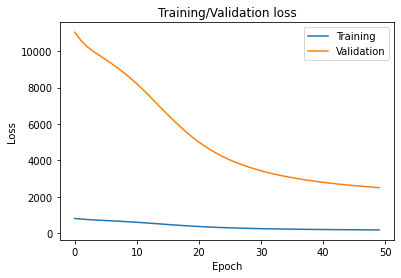

In [17]:
import matplotlib.pyplot as plt
plt.plot(training_result[:, 2], label="Training")
plt.plot(training_result[:, 5], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Validation loss")
plt.legend()
plt.savefig('Loss.png')   
plt.show()

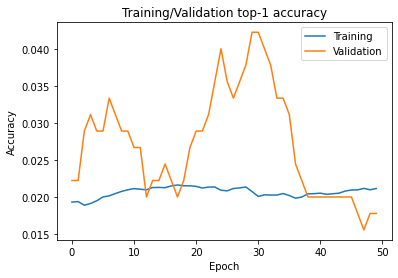

In [18]:
import matplotlib.pyplot as plt
plt.plot(training_result[:, 0], label="Training")
plt.plot(training_result[:, 3], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training/Validation top-1 accuracy")
plt.legend()
plt.savefig('Top1_acc.png')   
plt.show()

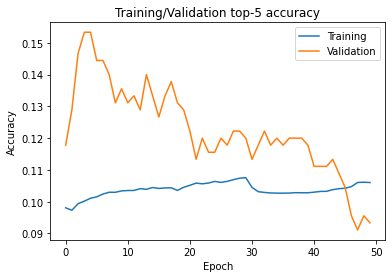

In [19]:
import matplotlib.pyplot as plt
plt.plot(training_result[:, 1], label="Training")
plt.plot(training_result[:, 4], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training/Validation top-5 accuracy")
plt.legend()
plt.savefig('Top5_acc.png')
plt.show()